In [100]:
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from scipy import stats
from tqdm import tqdm

In [101]:
year = "2014"

In [102]:
dataset_path = '2014_Accidents_UK.csv'
output_path_csv = 'clean_2014_test.csv'
df= pd.read_csv(dataset_path,index_col=2)
df.head()

,accident_index,accident_year,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
accident_reference,,,,,,,,,,,,,,,,,,,,,
01BS70001,201401BS70001,2014,524600,179020,-0.206443,51.496345,Metropolitan Police,Slight,2,1,...,No physical crossing facilities within 50 metres,Daylight,Raining no high winds,Wet or damp,None,None,Urban,No,Non-trunk,E01002814
01BS70002,201401BS70002,2014,525780,178290,-0.189713,51.489523,Metropolitan Police,Slight,2,1,...,Pedestrian phase at traffic signal junction,Darkness - lighting unknown,Fine no high winds,Dry,None,None,Urban,No,Non-trunk,E01002894
01BS70003,201401BS70003,2014,526880,178430,-0.173827,51.490536,Metropolitan Police,Slight,2,1,...,No physical crossing facilities within 50 metres,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,Non-trunk,E01002822
01BS70004,201401BS70004,2014,525580,179080,-0.192311,51.496668,Metropolitan Police,Slight,1,1,...,Zebra,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,No,Non-trunk,E01002812
01BS70006,201401BS70006,2014,527040,179030,-0.171308,51.495892,Metropolitan Police,Slight,2,1,...,Central refuge,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,Non-trunk,E01002821


In [103]:
df.describe()

,accident_year,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,speed_limit
count,146322.0,146322.000000,1.463220e+05,146322.000000,146322.000000,146322.000000,146322.000000,146322.000000
mean,2014.0,447029.362475,2.903741e+05,-1.328712,52.500882,1.835179,1.329103,38.238611
std,0.0,95158.326674,1.578227e+05,1.397358,1.421337,0.700208,0.857469,13.850167
min,2014.0,70951.000000,1.030400e+04,-7.450342,49.913077,1.000000,1.000000,20.000000
25%,2014.0,384364.250000,1.765900e+05,-2.235527,51.474928,1.000000,1.000000,30.000000
50%,2014.0,451306.000000,2.416200e+05,-1.238819,52.055124,2.000000,1.000000,30.000000
75%,2014.0,526830.000000,3.911760e+05,-0.170586,53.414623,2.000000,1.000000,40.000000
max,2014.0,655309.000000,1.190858e+06,1.758797,60.597984,21.000000,93.000000,70.000000


In [104]:
cols_drop_csv=[]
def add_to_col_drop(col):
  cols_drop_csv.append(col)

In [105]:
def show_values(axs, orient="v", round = 1,space=.01):
    format = '{:.'+str(round)+'f}'
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = format.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = format.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [106]:
def countEachCategory(col):
  allCategories = col.unique();
  res={}
  for cat in allCategories:
    res[str(cat)]=0
  for val in col:
    res[str(val)] = res[str(val)]+1
  return res

In [107]:
def percentOfCategories(col,fun=countEachCategory,r=1):
  countDict = fun(col)
  sumAll = len(col)
  for cat in countDict:
    countDict[cat] = round((countDict[cat]/sumAll)*100, r)
  return countDict

In [108]:
def convertDictTo2DList(dictOfRelation,yVal):
  res = []
  for d in dictOfRelation:
    temp =[]
    for y in yVal :
      temp.append(dictOfRelation[d][str(y)])
    res.append(temp)
  return res

In [109]:
def getDictOfListsOfTwoFeatures(df, feature1 , feature2,r=3,convertArray=False):
  xValues = df[feature2].unique()
  yValues = df[feature1].unique()
  dictOfRelation ={}
  for x in xValues:
    dictOfRelation[str(x)]=[]
  for x in xValues:
    perDict = percentOfCategories(df[df[feature2]==x][feature1],r=r)
    for y in yValues:
      if not(str(y) in perDict.keys()):
        perDict[str(y)]= 0
    dictOfRelation[x] = perDict
  if convertArray:
    dictOfRelationdictOfRelation = np.array(convertDictTo2DList(dictOfRelation))
  for i in range (0,len(xValues)):
    xValues[i] = str(xValues[i])
  for i in range (0,len(yValues)):
    yValues[i] = str(yValues[i])
  return dictOfRelation,xValues,yValues

In [110]:
def plotmultiBars(listOfRelation,xValues,yValues=None,xlabel="",ylabel="",log=False,width=0.1,dim1=14,dim2=8,degree=0):
  plt_1 = plt.figure(figsize=(dim1, dim2))
  x = np.arange(len(xValues))
  numberOfBars = len(listOfRelation[0])
  start = (numberOfBars*width)/2
  for i in range(0,len(listOfRelation[0])):
    if log:
      plt.bar(x-start + width/2 +(i*width),np.log(listOfRelation[:,i]) , width)
    else:
      plt.bar(x-start + width/2 +(i*width),listOfRelation[:,i] , width)
  plt.xticks(x, xValues,rotation=degree)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  if ylabel!=None:
    plt.legend(yValues)
  plt.show()

In [111]:
df.shape

(146322, 35)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146322 entries, 01BS70001 to 984139614
Data columns (total 35 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   accident_index                               146322 non-null  object 
 1   accident_year                                146322 non-null  int64  
 2   location_easting_osgr                        146322 non-null  int64  
 3   location_northing_osgr                       146322 non-null  int64  
 4   longitude                                    146322 non-null  float64
 5   latitude                                     146322 non-null  float64
 6   police_force                                 146322 non-null  object 
 7   accident_severity                            146322 non-null  object 
 8   number_of_vehicles                           146322 non-null  int64  
 9   number_of_casualties                         146322 n

In [113]:
df.isnull().sum()

accident_index                                     0
accident_year                                      0
location_easting_osgr                              0
location_northing_osgr                             0
longitude                                          0
latitude                                           0
police_force                                       0
accident_severity                                  0
number_of_vehicles                                 0
number_of_casualties                               0
date                                               0
day_of_week                                        0
time                                               0
local_authority_district                           0
local_authority_ons_district                       0
local_authority_highway                            0
first_road_class                                   0
first_road_number                                  0
road_type                                     

from first analysis we can see  second_road_number, road_type and weather_conditions have null values

###Column 0 is the accident year and all vaues 2014

In [114]:
add_to_col_drop('accident_year')

### Column 1 with 146322 values so no null values here. the column values represent reference to the accident and it is a suffix of the index after 2014

In [115]:
def checkvalidRefWithIndex(index,ref,prefix):
  c = 0
  if(len(index)!=len(ref)):
    return False;
  for i in range(0,len(ref)):
    refTIndex = prefix+ref[i]
    if(refTIndex!=index[i]):
      c+=1
  return c==0

# Cleaning

### All first roads have class label C or Unclassified if and only if these roads do not have road numbers

In [116]:
all_first_class_c_unclassified = df[df.first_road_class.isin(['C','Unclassified'])].first_road_number

In [117]:
all_first_class_c_unclassified.unique()

array(['first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero '],
      dtype=object)

In [118]:
text_of_missing_road_number = 'first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero '
all_road_without_number = df[df.first_road_number==text_of_missing_road_number].first_road_class
all_road_without_number

accident_reference
01BS70004               C
01BS70011               C
01BS70013               C
01BS70017    Unclassified
01BS70018               C
                 ...     
984122114               C
984124914               C
984129714               C
984131414    Unclassified
984133714    Unclassified
Name: first_road_class, Length: 54291, dtype: object

In [119]:
all_road_without_number.unique()

array(['C', 'Unclassified'], dtype=object)

### NAN Second Road Number

In [120]:
roadsNumberWithNegativeClass = df[df.second_road_class=='-1'].second_road_number
roadsNumberWithNegativeClass.unique()

array([nan], dtype=object)

all roads with -1 class have nan as a road number

In [121]:
road_classes_when_roads_with_NaN_number = df[df.second_road_number.isnull()].second_road_class
road_classes_when_roads_with_NaN_number.unique()

array(['-1', 'A', 'B'], dtype=object)

most of roads with nan as road number has -1 class

In [122]:
percent_road_classes_when_roads_with_NaN_number= percentOfCategories(road_classes_when_roads_with_NaN_number,r=3)
percent_road_classes_when_roads_with_NaN_number

{'-1': 99.996, 'A': 0.002, 'B': 0.002}

#### replace all roads with -1 class to have -1 as road number

In [123]:
def countRoadWithoutNumber(x):
  res={}
  for road in x:
    road = str(road)
    if road=='nan':
      if(road in res):
        res[road]=res[road]+1
      else:
        res[road]=1
    try:
      float(road)
    except:
      if(road in res):
        res[road]=res[road]+1
      else:
        res[road]=1
        
  return res

In [124]:
no_second_road_then_no_number = '-1'
df.second_road_number= np.where(df.second_road_class == '-1', no_second_road_then_no_number,df.second_road_number)

In [125]:
percent_Missing_second_road_number_after_filter = percentOfCategories(df.second_road_number,r=3,fun=countRoadWithoutNumber)
percent_Missing_second_road_number_after_filter

{'first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero ': 46.292,
 'nan': 0.001}

0.001 nan which low percentage so it may be noise 
we will drop them  

In [126]:
df.dropna(subset = ['second_road_number'], inplace=True)

In [127]:
has_no_number = '0'
df.second_road_number= np.where(df.second_road_number == 'first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero ', has_no_number,df.second_road_number)
df.first_road_number= np.where(df.first_road_number == 'first_road_class is C or Unclassified. These roads do not have official numbers so recorded as zero ', has_no_number,df.first_road_number)

In [128]:
percent_Missing_second_road_number_after_filter_after_drop = percentOfCategories(df.second_road_number,r=3,fun=countRoadWithoutNumber)
percent_Missing_second_road_number_after_filter_after_drop

{}

### Road type NaN

In [129]:
road_class_when_road_type_isnull = df[df.road_type.isnull()].first_road_class

In [130]:
percent_road_class_when_road_type_isnull = percentOfCategories(road_class_when_road_type_isnull,r=3)
percent_road_class_when_road_type_isnull

{'Unclassified': 58.103,
 'B': 9.091,
 'C': 4.941,
 'A': 24.506,
 'Motorway': 2.964,
 'A(M)': 0.395}

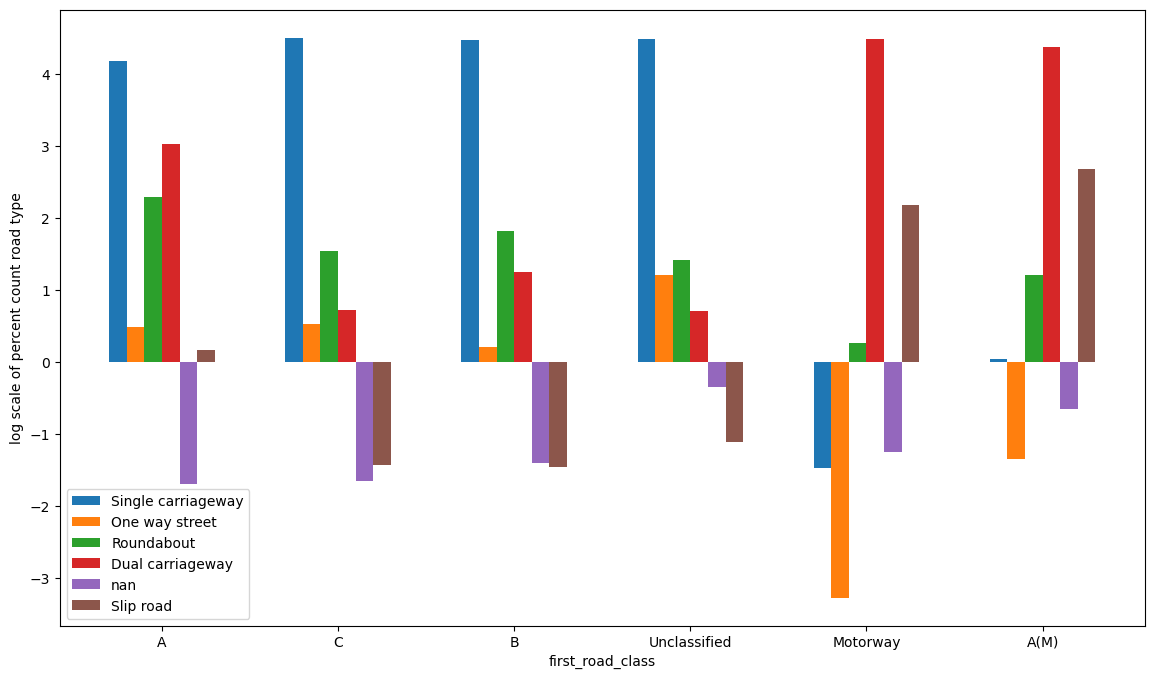

In [131]:
x,a,b = getDictOfListsOfTwoFeatures(df,'road_type','first_road_class')
x =np.array(convertDictTo2DList(x,b))
plotmultiBars(x,a,b,log=True,xlabel='first_road_class',ylabel='log scale of percent count road type')

nans are distributed among all road types so we can say missing is random and we will drop them since nan represent 0.3%

In [132]:
df.dropna(subset = ['road_type'], inplace=True)

### weather_conditions NaNs

In [133]:
percentOfCategories(df[df.weather_conditions.isnull()].police_force,r=3)

{'Metropolitan Police': 23.216,
 'City of London': 0.082,
 'Cumbria': 1.025,
 'Lancashire': 1.354,
 'Merseyside': 1.682,
 'Greater Manchester': 2.666,
 'Cheshire': 1.436,
 'Northumbria': 0.861,
 'Durham': 0.369,
 'North Yorkshire': 0.369,
 'West Yorkshire': 2.461,
 'South Yorkshire': 7.834,
 'Humberside': 0.082,
 'West Midlands': 9.721,
 'Staffordshire': 0.41,
 'West Mercia': 0.082,
 'Derbyshire': 2.543,
 'Nottinghamshire': 3.651,
 'Lincolnshire': 3.322,
 'Leicestershire': 1.6,
 'Northamptonshire': 0.328,
 'Cambridgeshire': 2.748,
 'Norfolk': 0.082,
 'Suffolk': 0.984,
 'Bedfordshire': 0.041,
 'Hertfordshire': 1.682,
 'Essex': 0.697,
 'Thames Valley': 1.395,
 'Hampshire': 0.984,
 'Surrey': 5.578,
 'Kent': 7.957,
 'Sussex': 2.748,
 'Devon and Cornwall': 0.861,
 'Avon and Somerset': 2.297,
 'Gloucestershire': 0.041,
 'Dorset': 0.041,
 'North Wales': 0.738,
 'Gwent': 0.492,
 'South Wales': 0.41,
 'Dyfed-Powys': 0.861,
 'Northern': 0.328,
 'Grampian': 0.451,
 'Fife': 0.164,
 'Lothian and Bo

In [134]:
percentOfCategories(df[df.weather_conditions.isnull()].accident_severity,r=3)

{'Slight': 88.843, 'Serious': 10.541, 'Fatal': 0.615}

In [135]:
percentOfCategories(df[df.weather_conditions.isnull()].day_of_week,r=3)

{'Saturday': 14.069,
 'Wednesday': 16.161,
 'Monday': 12.1,
 'Tuesday': 15.751,
 'Thursday': 16.325,
 'Sunday': 10.049,
 'Friday': 15.546}

In [136]:
percentOfCategories(df[df.weather_conditions.isnull()].first_road_class,r=3)

{'A': 44.34,
 'C': 9.557,
 'Unclassified': 31.501,
 'B': 12.059,
 'Motorway': 2.297,
 'A(M)': 0.246}

In [137]:
percentOfCategories(df[df.weather_conditions.isnull()].road_type,r=3)

{'Single carriageway': 75.554,
 'Dual carriageway': 12.141,
 'One way street': 2.707,
 'Roundabout': 8.819,
 'Slip road': 0.779}

In [138]:
percentOfCategories(df[df.weather_conditions.isnull()].light_conditions,r=3)

{'Daylight': 65.299,
 'Darkness - lighting unknown': 12.223,
 'Darkness - lights lit': 18.868,
 'Darkness - lights unlit': 0.533,
 'Darkness - no lighting': 3.076}

In [139]:
percentOfCategories(df[df.weather_conditions.isnull()].road_surface_conditions,r=3)

{'Dry': 72.97,
 'Wet or damp': 20.139,
 'Frost or ice': 0.902,
 'Data missing or out of range': 5.865,
 'Flood over 3cm. deep': 0.082,
 'Snow': 0.041}

no relation between nans in weather conditions with any features all nans are distributed normally. nans represnts 1.7%
so we will drop nan 

In [140]:
df.dropna(subset = ['weather_conditions'], inplace=True)

In [141]:
df.isnull().sum()

accident_index                                 0
accident_year                                  0
location_easting_osgr                          0
location_northing_osgr                         0
longitude                                      0
latitude                                       0
police_force                                   0
accident_severity                              0
number_of_vehicles                             0
number_of_casualties                           0
date                                           0
day_of_week                                    0
time                                           0
local_authority_district                       0
local_authority_ons_district                   0
local_authority_highway                        0
first_road_class                               0
first_road_number                              0
road_type                                      0
speed_limit                                    0
junction_detail     

### Missing in junction_control feature

In [142]:
Data_missing_or_out_of_range = 'Data missing or out of range'

In [143]:
percentOfCategories(df[df.junction_control==Data_missing_or_out_of_range].junction_detail,r=3)

{'Not at junction or within 20 metres': 99.89,
 'Other junction': 0.063,
 'Private drive or entrance': 0.033,
 'T or staggered junction': 0.009,
 'Roundabout': 0.004,
 'Slip road': 0.002}

when junction_control is Data_missing_or_out_of_range 99.89% of junction detail is Not at junction or within 20 metres.
replace junction control with missing to Not at junction then no control when junction detail = Not at junction or within 20 metres

In [144]:
Not_at_junction_then_no_control= 'Not at junction then no control'
Not_at_junction_or_within_20_metres = 'Not at junction or within 20 metres'
df.junction_control= np.where((df.junction_detail == Not_at_junction_or_within_20_metres) & (df.junction_control==Data_missing_or_out_of_range), Not_at_junction_then_no_control,df.junction_control)

In [145]:
percentOfCategories(df[df.junction_detail==Not_at_junction_or_within_20_metres].junction_control,r=3)

{'Not at junction then no control': 99.991,
 'Give way or uncontrolled': 0.007,
 'Auto traffic signal': 0.002}

drop accidents with junction_detail =Not_at_junction_or_within_20_metres and junction_control!=Not_at_junction_then_no_control.
not a correct situation for having a value for junction_control and there is no junction

In [146]:
df = df[(df.junction_detail!=Not_at_junction_or_within_20_metres) | (df.junction_control==Not_at_junction_then_no_control)]

In [147]:
percentOfCategories(df[df.junction_detail==Not_at_junction_or_within_20_metres].junction_control,r=3)

{'Not at junction then no control': 100.0}

only 61 records with missing junction_control.
Drop missing in junction_control

In [148]:
len(df[df.junction_control==Data_missing_or_out_of_range].junction_detail)

61

In [149]:
df = df[df.junction_control!=Data_missing_or_out_of_range]

### Missing in road_surface_conditions feature

drop missing in road_surface_conditions column only 0.15% missing so missing is random

In [150]:
df = df[df.road_surface_conditions!=Data_missing_or_out_of_range]

drop missing in special_conditions_at_site column only 0.001% missing so missing is random

In [151]:
df = df[df.special_conditions_at_site!=Data_missing_or_out_of_range]

drop missing in carriageway_hazards column only 0.001% missing so missing is random

In [152]:
df = df[df.carriageway_hazards!=Data_missing_or_out_of_range]

### Missing in trunk_road_flag feature

In [153]:
percentOfCategories(df.trunk_road_flag,r=3)

{'Non-trunk': 82.676,
 'Trunk (Roads managed by Highways England)': 7.282,
 'Data missing or out of range': 10.042}

In [154]:
percentOfCategories(df[df.trunk_road_flag==Data_missing_or_out_of_range].first_road_class,r=3)

{'B': 14.767,
 'A': 44.601,
 'Unclassified': 34.423,
 'C': 2.378,
 'Motorway': 3.622,
 'A(M)': 0.209}

In [155]:
percentOfCategories(df[df.trunk_road_flag==Data_missing_or_out_of_range].road_type,r=3)

{'Single carriageway': 76.069,
 'Dual carriageway': 14.496,
 'Slip road': 1.126,
 'Roundabout': 6.306,
 'One way street': 2.002}

In [156]:
percentOfCategories(df[df.trunk_road_flag==Data_missing_or_out_of_range].junction_detail,r=3)

{'Crossroads': 7.3,
 'Not at junction or within 20 metres': 48.091,
 'T or staggered junction': 24.842,
 'Other junction': 5.263,
 'Mini-roundabout': 0.577,
 'Roundabout': 8.656,
 'Private drive or entrance': 2.545,
 'More than 4 arms (not roundabout)': 0.897,
 'Slip road': 1.829}

In [157]:
def trunk_road_flag_missing(df, missing='Data missing or out of range', default='Non-trunk'):
    res = []  # Initialize an empty list to store the new values for the trunk_road_flag column
    values = df.trunk_road_flag.unique()  # Get the unique values in the trunk_road_flag column
    c = 0  # Initialize a counter variable
    for i in tqdm(range(0, len(df))):  # Loop through each row in the DataFrame
        x = df.iloc[i]  # Get the current row
        if x['trunk_road_flag'] == missing:  # Check if the value in the trunk_road_flag column is missing
            # Filter the DataFrame to include only rows where the trunk_road_flag column is not equal to 'Data missing or out of range' and the first_road_number column is equal to x['first_road_number']
            y = df[(df.trunk_road_flag != 'Data missing or out of range') & (df.first_road_number == x['first_road_number'])].trunk_road_flag.unique()
            if len(y) > 0:  # Check if there are any rows that meet the above conditions
                max = 0  # Initialize a variable to store the maximum count
                s = ""  # Initialize a variable to store the most common value
                for v in y:  # Loop through each unique value in y
                    # Filter the DataFrame to include only rows where the trunk_road_flag column is equal to v and the first_road_number column is equal to x['first_road_number']
                    z = df[(df.trunk_road_flag == v) & (df.first_road_number == x['first_road_number'])]
                    if len(z) > max:  # Check if this value occurs more often than the current maximum count
                        max = len(z)  # Update the maximum count
                        s = v  # Update the most common value
                res.append(s)  # Add the most common value to the res list
            else:  # If no rows meet the above conditions
                temp = df[df.first_road_class == x['first_road_class']]  # Filter the DataFrame to include only rows where the first_road_class column is equal to x['first_road_class']
                y = temp.trunk_road_flag.unique()  # Get the unique values in the trunk_road_flag column for these rows
                if len(y) > 0:  # Check if there are any rows that meet this condition
                    max = 0  # Initialize a variable to store the maximum count
                    s = ""  # Initialize a variable to store the most common value
                    for v in y:  # Loop through each unique value in y
                        # print(v,y)
                        # print(df.index)
                        # print(df.index.duplicated())
                        z = temp[df.trunk_road_flag == v]  # Filter temp to include only rows where trunk_road_flag is equal to v
                        if len(z) > max:  # Check if this value occurs more often than the current maximum count
                            max = len(z)  # Update the maximum count
                            s = v  # Update the most common value
                    res.append(s)  # Add the most common value to res list
                else:  # If no rows meet this condition either
                    c += 1  
                    res.append(default)   # Add default value to res list 
        else:
            res.append(x['trunk_road_flag'])   # If trunk road flag is not missing, add it as it is 
    df['trunk_road_flag'] = res   # Update trunk road flag column with new values 


In [158]:
trunk_road_flag_missing(df)

 90%|████████▉ | 128483/143234 [00:25<00:03, 4403.55it/s]C:\Users\Bassem\AppData\Local\Temp\ipykernel_15940\287686575.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  z = temp[df.trunk_road_flag == v]  # Filter temp to include only rows where trunk_road_flag is equal to v
100%|██████████| 143234/143234 [36:04<00:00, 66.17it/s]  


no correlation between missing and any column. but we can use road number column to restore missing values if row x has missing trunk road flag value we search for accident in the same firt road number and use its trunk road value for road x if no roads with same number as x we use the first road class

In [159]:

# res = []
# for y in df.first_road_number:
#   res.append(int(y))
# df['first_road_number_num'] =res
# cols_to_be_droped.append('first_road_number')

In [160]:
# res = []
# for y in df.second_road_number:
#   res.append(int(float(y)))
# df['second_road_number_num'] =res
# cols_to_be_droped.append('second_road_number')

### duplicate columns local_authority_district and local_authority_ons_district 
columns have same values but some areas recoded in diffirent format like St St. Edmundsbury and St Edmundsbury
drop one of them

In [161]:
df[df['local_authority_district']!=df['local_authority_ons_district']]['local_authority_ons_district'].unique()

array(['Stratford-on-Avon', 'St Edmundsbury', 'St Albans',
       'Isles of Scilly', 'Rhondda Cynon Taf', 'Vale of Glamorgan',
       'Comhairle nan Eilean Siar', 'City of Edinburgh'], dtype=object)

In [162]:
df[df['local_authority_district']!=df['local_authority_ons_district']]['local_authority_district'].unique()

array(['Stratford-upon-Avon', 'St. Edmundsbury', 'St. Albans', 'Cornwall',
       'Rhondda, Cynon, Taff', 'The Vale of Glamorgan', 'Western Isles',
       'Edinburgh, City of'], dtype=object)

In [163]:
add_to_col_drop('local_authority_ons_district')

### duplicate columns longitude latitude and location_easting_osgr 	location_northing_osgr 
high correlation between them and each two columns represent location so we can drop two of them

In [164]:
df[['location_northing_osgr' , 'latitude']].corr()

,location_northing_osgr,latitude
location_northing_osgr,1.000000,0.999972
latitude,0.999972,1.000000


In [165]:
df[['location_easting_osgr' , 'longitude']].corr()

,location_easting_osgr,longitude
location_easting_osgr,1.000000,0.999389
longitude,0.999389,1.000000


In [166]:
add_to_col_drop('location_easting_osgr')
add_to_col_drop('location_northing_osgr')

## Outliers

In [167]:
def outliersLOF(df,featureX,featureY):
  clf = LocalOutlierFactor()
  X = df[[featureX,featureY]].values
  y_pred = clf.fit_predict(X)
  plt.figure(figsize=(12,12))
  # plot the level sets of the decision function

  in_mask = [True if l == 1 else False for l in y_pred]
  out_mask = [True if l == -1 else False for l in y_pred]

  plt.title("Local Outlier Factor (LOF)")
  # inliers
  a = plt.scatter(X[in_mask, 0], X[in_mask, 1], c = 'blue',
                  edgecolor = 'k', s = 30)
  # outliers
  b = plt.scatter(X[out_mask, 0], X[out_mask, 1], c = 'red',
                  edgecolor = 'k', s = 30)
  plt.axis('tight')
  plt.xlabel(featureX);
  plt.ylabel(featureY);
  plt.show()
  c = 0
  for b in out_mask:
    if b :
      c+=1
  return in_mask,c


In [168]:
def outliersBox(df,feature):
  Q1 = df[feature].quantile(0.25)
  Q3 = df[feature].quantile(0.75)
  IQR = Q3 - Q1
  cut_off = IQR * 1.5
  lower = Q1 - cut_off
  upper =  Q3 + cut_off
  in_mask = (df[feature] < upper) & (df[feature] > lower)
  c = 0
  for b in in_mask:
    if not(b) :
      c+=1
  plt.boxplot(df[feature])
  plt.show()
  return in_mask,c

In [169]:
def outlierZScore(df,feature,th=3):
  z = np.abs(stats.zscore(df[feature]))
  in_mask = z < th*z.std() + z.mean()
  c = 0
  for b in in_mask:
    if not(b) :
      c+=1
  return in_mask,c

  

### outlier number_of_vehicles and number_of_casualties. Box method classified huge number of rows as outliers since it does not take int considtration the relation between features. LOF is the best with 160 recodes as outliers

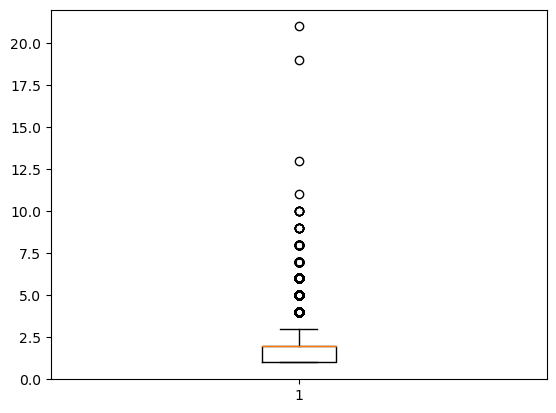

In [170]:
Box_in_mask_number_of_vehicles,Box_countOutliers_number_of_vehicles = outliersBox(df,'number_of_vehicles')

In [171]:
Box_countOutliers_number_of_vehicles

3190

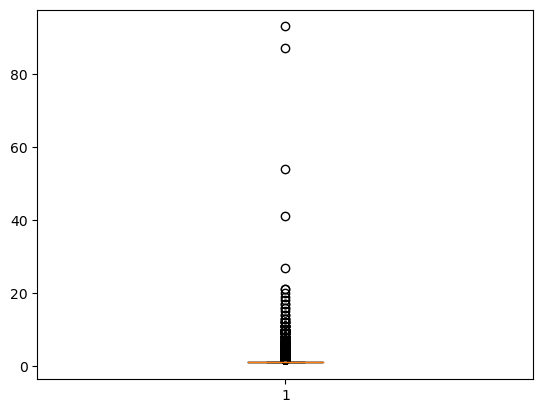

In [172]:
Box_in_mask_number_of_casualties,Box_countOutliers_number_of_casualties = outliersBox(df,'number_of_casualties')

In [173]:
Box_countOutliers_number_of_casualties

143234

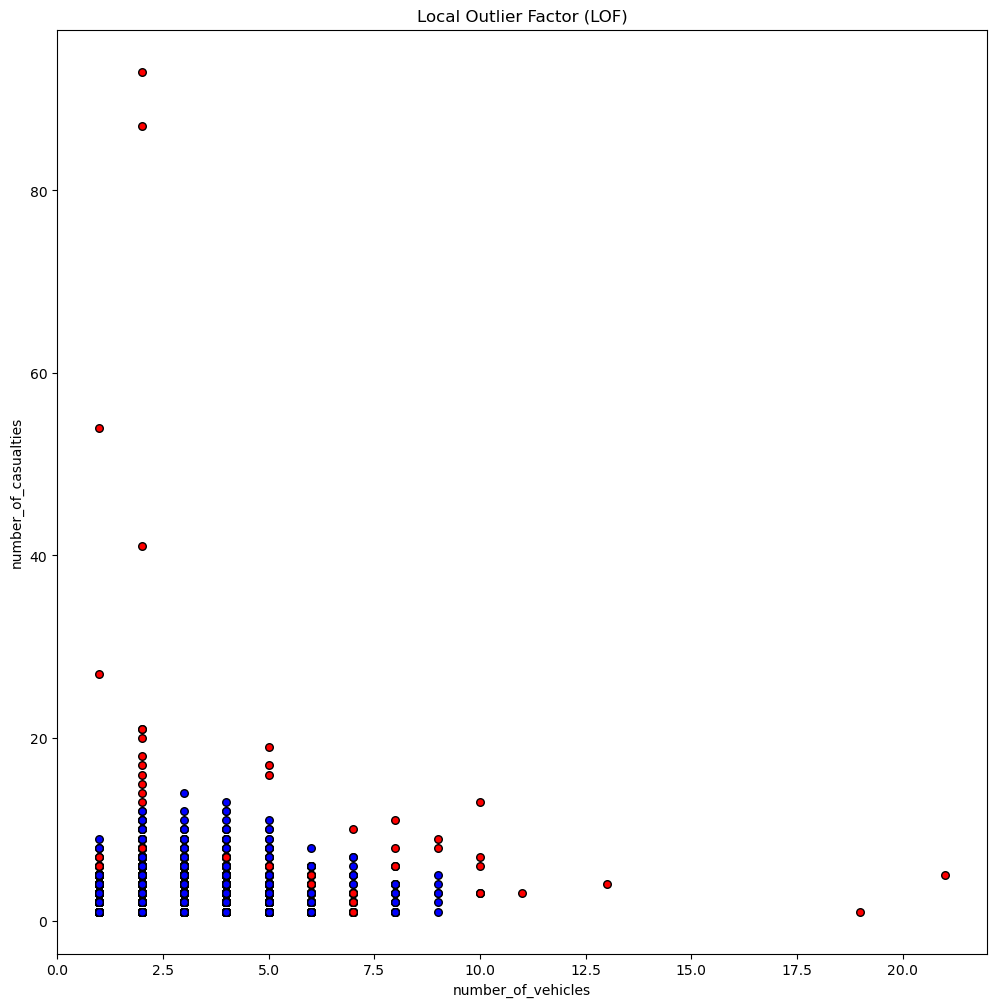

In [174]:
LOF_in_mask_number_of_vehicles_number_of_casualties,LOF_countOutliers_number_of_vehicles_number_of_casualties = outliersLOF(df,'number_of_vehicles','number_of_casualties')

In [175]:
LOF_countOutliers_number_of_vehicles_number_of_casualties

160

#### drop all outliers from LOF since all of them only 160

In [176]:
df = df[LOF_in_mask_number_of_vehicles_number_of_casualties]

### location features using Box plot

#### longitude

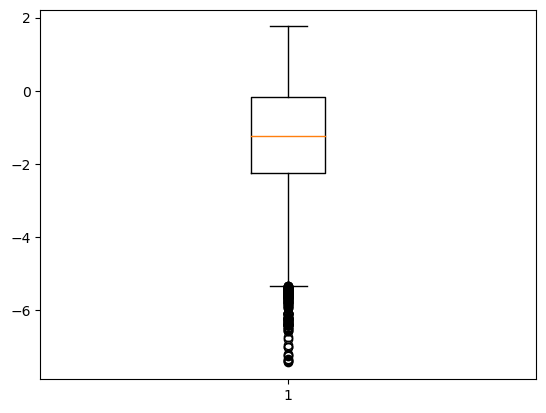

In [177]:
Box_in_mask_longitude,Box_countOutliers_longitude = outliersBox(df,'longitude')

In [178]:
Box_countOutliers_longitude

285

In [179]:
Z_in_mask_longitude,Z_countOutliers_longitude =outlierZScore(df,'longitude',th=3)

In [180]:
Z_countOutliers_longitude

1252

In [181]:
Z_in_mask_longitude,Z_countOutliers_longitude =outlierZScore(df,'longitude',th=4)

In [182]:
Z_countOutliers_longitude

84

drop all outliers (from ZScore method with th = 4) since outliers represent only 0.06%

In [183]:
df = df[Z_in_mask_longitude]

#### latitude

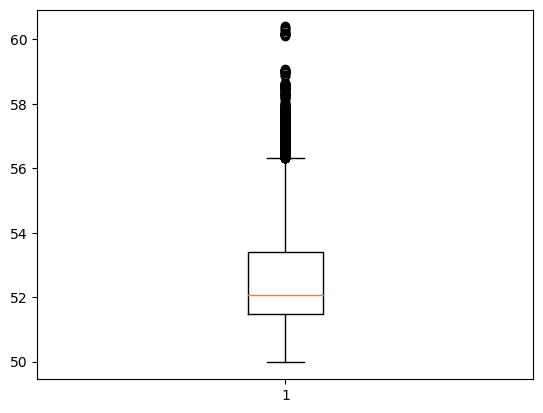

In [184]:
Box_in_mask_latitude,Box_countOutliers_latitude = outliersBox(df,'latitude')

In [185]:
Box_countOutliers_latitude

1739

In [186]:
Z_in_mask_latitude,Z_countOutliers_latitude =outlierZScore(df,'latitude',th=3)

In [187]:
Z_countOutliers_latitude

2062

In [188]:
Z_in_mask_latitude,Z_countOutliers_latitude =outlierZScore(df,'latitude',th=5)

In [189]:
Z_countOutliers_latitude

120

drop all outliers (from ZScore method with th = 4) since outliers represent only 0.1%

In [190]:
df = df[Box_in_mask_latitude]

same outliers for location_easting_osgr and location_northing_osgr because of the strong correlation between them

### speed_limit

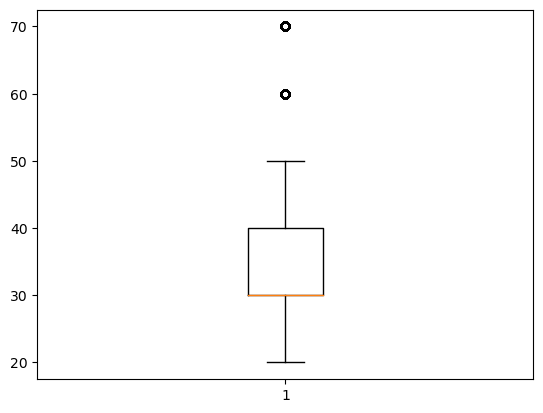

In [191]:
Box_in_mask_speed_limit,Box_countOutliers_speed_limit = outliersBox(df,'speed_limit')

In [192]:
Box_countOutliers_speed_limit

28650

In [193]:
Z_in_mask_speed_limit,Z_countOutliers_speed_limit = outlierZScore(df,'speed_limit')

In [194]:
Z_countOutliers_speed_limit

0

Box plot method classify all speeds more then 50 as outliers which is not correct.
so Z score more accurate

# Duplicates

In [195]:
duplicates = df[df.duplicated(subset=['longitude','latitude','date','time'])]
len(duplicates)

5

In [196]:
df = df.drop_duplicates(subset=['longitude','latitude','date','time'])

any two accidents in the same location and same date and time considered as a dup;icated so we drop 

# Encoding

In [197]:
def convert_date_time_week(df):
  result = df.copy()
  day=[]
  month=[]
  week=[]
  hour =[]
  minute= []
  for i in range(0,df.shape[0]):
    date_object = datetime.strptime(result['date'][i],'%d/%m/%Y')
    day.append(date_object.day)
    month.append(date_object.month)
    week.append(date_object.isocalendar()[1])
    time_object = datetime.strptime(result['time'][i],'%H:%M')
    hour.append(time_object.hour)
    minute.append(time_object.minute)
  df['day'] = day
  df['month'] = month
  df['hour']=hour
  df['minute'] = minute

In [198]:
convert_date_time_week(df)

In [199]:
def number_encode_features(df,feature,mapping):
    result = df.copy() # take a copy of the dataframe
    map = []
    for x in df[feature]:
      map.append(mapping[x])
    result[feature+'_encoding'] = np.array(map)
    return result

In [200]:
def one_hot_encoding(df,feature,drop_col=None,prefix=None):
  result = pd.get_dummies(df[feature])
  if drop_col!=None:
    result = result.drop([drop_col],axis=1)
  if prefix==None:
    prefix = feature
    
  result = result.add_prefix(prefix+'_')
  res = pd.concat([df, result], axis = 1)
  return res


In [201]:
def calculate_top_categories(df, variable, how_many):
    return [
        x for x in df[variable].value_counts().sort_values(
            ascending=False).head(how_many).index
    ]

def one_hot_encode_frequent(df, variable, how_many):
    result = df.copy()
    top_x_labels = calculate_top_categories(result, variable, how_many)
    for label in top_x_labels:
        result[variable + '_' + label] = np.where(
            result[variable] == label, 1, 0) 
    return result

In [202]:
def generateLabelsMapping(df,feature):
  x = df[feature].unique()
  map = {}
  n = 0
  for i in x:
    map[i] = n
    n+=1
  return map


### accident_severity label encoding feature is ordinal

In [206]:
df['accident_severity'].unique()

array(['Slight', 'Serious', 'Fatal'], dtype=object)

In [208]:
mapping_accident_severity={'Slight':0, 'Serious':1, 'Fatal':2}
df = number_encode_features(df,'accident_severity',mapping_accident_severity)
add_to_col_drop('accident_severity')

### day_of_week endcoded with one hot encoding k-1 the feature not ordinal

In [209]:
df = one_hot_encoding(df,'day_of_week','Friday')

In [211]:
add_to_col_drop('day_of_week')

### first_road_class endcoded with one hot encoding k-1 the feature not ordinal

In [212]:
df = one_hot_encoding(df,'first_road_class','Unclassified')

In [213]:
add_to_col_drop('first_road_class')

### road_type endcoded with one hot encoding k-1 the feature not ordinal

In [214]:
df = one_hot_encoding(df,'road_type','Slip road')

In [215]:
add_to_col_drop('road_type')

### junction_detail endcoded with one hot encoding the most 5 frequent values since the remaining represent small value. the feature not ordinal

In [216]:
df = one_hot_encode_frequent(df, 'junction_detail', 5)

In [217]:
add_to_col_drop('junction_detail')

###junction_control endcoded with one hot encoding the most 3 frequent values since the remaining represent small value. the feature not ordinal

In [218]:
df = one_hot_encode_frequent(df, 'junction_control', 3)

In [219]:
add_to_col_drop('junction_control')

### second_road_class endcoded with one hot encoding k-1 the feature not ordinal

In [220]:
df = one_hot_encoding(df,'second_road_class','Unclassified')

In [221]:
add_to_col_drop('second_road_class')

### pedestrian_crossing_human_control endcoded with one hot encoding the most frequent value since the remaining represent small value. the feature not ordinal

In [222]:
df = one_hot_encode_frequent(df,'pedestrian_crossing_human_control',1)

In [223]:
add_to_col_drop('pedestrian_crossing_human_control')

### pedestrian_crossing_physical_facilities endcoded with one hot encoding the most 3 frequent values since the remaining represent small value. the feature not ordinal

In [224]:
df = one_hot_encode_frequent(df,'pedestrian_crossing_physical_facilities',3)

In [225]:
add_to_col_drop('pedestrian_crossing_physical_facilities')

### light_conditions label encoding feature is ordinal

In [226]:
df.light_conditions.unique()

array(['Daylight', 'Darkness - lighting unknown', 'Darkness - lights lit',
       'Darkness - lights unlit', 'Darkness - no lighting'], dtype=object)

In [227]:
mapping_light_conditions = {'Daylight':0, 'Darkness - lighting unknown':1, 'Darkness - lights lit':2,
       'Darkness - lights unlit':3, 'Darkness - no lighting':4}

In [228]:
df = number_encode_features(df,'light_conditions',mapping_light_conditions)

In [229]:
add_to_col_drop('light_conditions')

### weather_conditions endcoded with one hot encoding the most 2 frequent values since the remaining represent small value. the feature not ordinal

In [230]:
df = one_hot_encode_frequent(df,'weather_conditions',2)

In [231]:
add_to_col_drop('weather_conditions')

### road_surface_conditions endcoded with one hot encoding the most 2 frequent values since the remaining represent small value. the feature not ordinal

In [232]:
df = one_hot_encode_frequent(df,'road_surface_conditions',2)

In [233]:
add_to_col_drop('road_surface_conditions')

### special_conditions_at_site endcoded with one hot encoding the most frequent value since the remaining represent small value. the feature not ordinal

In [234]:
df = one_hot_encode_frequent(df,'special_conditions_at_site',1)

In [235]:
add_to_col_drop('special_conditions_at_site')

### carriageway_hazards endcoded with one hot encoding the most frequent value since the remaining represent small value. the feature not ordinal

In [236]:
df = one_hot_encode_frequent(df,'carriageway_hazards',1)

In [237]:
add_to_col_drop('carriageway_hazards')

### urban_or_rural_area endcoded with one hot encoding k-1 the feature not ordinal

In [238]:
df = one_hot_encoding(df,'urban_or_rural_area','Urban')

In [239]:
add_to_col_drop('urban_or_rural_area')

### did_police_officer_attend_scene_of_accident endcoded with one hot encoding k-1 the feature not ordinal

In [240]:
df = one_hot_encoding(df,'did_police_officer_attend_scene_of_accident','No')

In [241]:
add_to_col_drop('did_police_officer_attend_scene_of_accident')

### police_force encoded with label encoding methed the feature not ordinal but it has huge number of unique values so one hot encoding will consume huge memory space. The percentage of unique values almost have no differance so we can not use freqent version of one hot encoding


In [242]:
df = number_encode_features(df,'police_force',generateLabelsMapping(df,'police_force'))

In [243]:
add_to_col_drop('police_force')

### trunck road flag endcoded with one hot encoding k-1 the feature not ordinal it almost binary two values

In [244]:
df = one_hot_encoding(df,'trunk_road_flag','Non-trunk')

In [245]:
add_to_col_drop('trunk_road_flag')

### local_authority_district, local_authority_highway and lsoa_of_accident_location same as police force

In [246]:
df = number_encode_features(df,'local_authority_district',generateLabelsMapping(df,'local_authority_district'))

In [247]:
add_to_col_drop('local_authority_district')

In [248]:
df = number_encode_features(df,'local_authority_highway',generateLabelsMapping(df,'local_authority_highway'))

In [249]:
add_to_col_drop('local_authority_highway')

# Discretization

In [250]:
def parsing_road(x):
  return int(float(x))
def parsing_LSOA(x):
  return int(float(x[2:]))

def intervals(df,feature,number_of_labels,fun = parsing_road):
  x = df[feature].unique()
  y = []
  for a in x:
    y.append(fun(a))
  y.sort()
  step = (len(y)//number_of_labels)+1
  intervals = [y[0]]
  i = step
  while i<len(y):
    intervals.append(y[i])
    i+=step
  if intervals[-1]==y[-1]:
    intervals[-1] = intervals[-1] +1
  else:
    intervals.append(y[-1]+1)
  return intervals

In [251]:
def discretize(df,feature,intervals,fun= parsing_road,offset=0):
  result = df.copy()
  res = []
  for x in df[feature]:
    x = fun(x)
    for i in range(1,len(intervals)):
      if intervals[i]>x:
        res.append(i-1)
        break
  result[feature+'_encoding'] = np.array(res)
  return result

In [252]:
def discretizeLSOA(df,number_of_labels,add_csv=True):
  result = df.copy()
  res = []
  intervalsW,intervalsE = intervalsLSOA(result,number_of_labels)
  for i in tqdm(range(0,len(result))):
    x = result.iloc[i]['lsoa_of_accident_location']
    if x=='-1':
      res.append('-1')
      continue
    num = int(x[2:])
    if x[0]=='W':
      f = False
      for i in range(1,len(intervalsW)):
        if intervalsW[i]>num:
          res.append(i-1)
          f = True
          break
      if not(f):
        print(x,'W')

    elif x[0]=='E':
      f = False
      for i in range(0,len(intervalsE)):
        if intervalsE[i]>num:
          res.append(i-1+len(intervalsW))
          f = True
          break
      if not(f):
        print(x,'E')
  if add_csv :
    add_to_col_drop('lsoa_of_accident_location')
  result['lsoa_of_accident_location_encoding'] = np.array(res)
  return result

In [253]:
def intervalsLSOA(df,number_of_labels):
  w = []
  e = []
  for x in df.lsoa_of_accident_location:
    if x=='-1':
      continue
    num = int(x[2:])
    if (x[0]=='W') &(not(num in w)):
      w.append(num)
    elif (x[0]=='E') &(not(num in e)):
      e.append(num)
    elif (x[0]!='W') & (x[0]!='E'):
      print(w)
  w.sort()
  e.sort()
  intervalsW = getInterval(w,number_of_labels)
  intervalsE = getInterval(e,number_of_labels)
  return intervalsW,intervalsE



In [254]:
def getInterval(y,number_of_labels):
  step = (len(y)//number_of_labels)+1
  intervals = [y[0]]
  i = step
  while i<len(y):
    intervals.append(y[i])
    i+=step
  if intervals[-1]==y[-1]:
    intervals[-1] = intervals[-1] +1
  else:
    intervals.append(y[-1]+1)
  return intervals


In [255]:
def add_intervals_to_csv(feature,intervals,offset = 0 , prefix=""):
  for i in range(0,len(intervals)-1):
    add_to_csv_values(feature+'_encoding',str(int(i+offset)),feature+" in intrval ["+prefix+str(intervals[i])+" , "+prefix+str(intervals[i+1])+"[")


### First road and second road can be parsed to integers so can be discretized each interval with label since road numbers have huge number of unique values

In [256]:
# df = discretize(df,'first_road_number',intervals(df,'first_road_number',15))

In [257]:
# df = discretize(df,'second_road_number',intervals(df,'second_road_number',15))

In [258]:
add_to_col_drop('first_road_number')
add_to_col_drop('second_road_number')

### lsoa_of_accident_location same as road number if we remove first char which 'w' or 'E' we can see the feature as integers and ordinal 
we discretize the feature with label for each interval

In [259]:
df = discretizeLSOA(df,20)

100%|██████████| 141246/141246 [00:36<00:00, 3884.99it/s]


# Normalization

In [262]:
def minMax(df):
  for column in df.columns:
    if df.dtypes[column] != np.object:
      scaled = MinMaxScaler().fit_transform(df[[column]])
      df[column] = scaled 

In [263]:
def Box_Cox(df,feature):
  index_of_positive = df[feature] > 0
  positive_rows = df[feature].loc[index_of_positive]
  normalized = stats.boxcox(positive_rows)[0]
  fig, ax=plt.subplots(1,2)
  sns.distplot(positive_rows, ax=ax[0])
  ax[0].set_title("Original Data")
  sns.distplot(normalized, ax=ax[1])
  ax[1].set_title("Normalized data")
  return normalized


In [264]:
df.describe()

,accident_year,location_easting_osgr,location_northing_osgr,longitude,latitude,number_of_vehicles,number_of_casualties,speed_limit,day,month,...,road_surface_conditions_Wet or damp,special_conditions_at_site_None,carriageway_hazards_None,urban_or_rural_area_Rural,did_police_officer_attend_scene_of_accident_Yes,police_force_encoding,trunk_road_flag_Trunk (Roads managed by Highways England),local_authority_district_encoding,local_authority_highway_encoding,week_number_encoding
count,141246.0,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000,...,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000,141246.000000
mean,2014.0,448435.060426,283647.963142,-1.306413,52.440454,1.835648,1.325036,38.176515,15.510506,6.625703,...,0.287074,0.978109,0.983766,0.339040,0.823613,18.725529,0.078416,157.859316,90.584809,1.930426
std,0.0,94486.104531,147157.820722,1.383973,1.325813,0.685026,0.746866,13.813652,8.715658,3.433736,...,0.452398,0.146328,0.126375,0.473385,0.381151,14.315792,0.268827,111.016545,50.513831,1.368626
min,2014.0,138554.000000,13264.000000,-5.654437,49.975186,1.000000,1.000000,20.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.0,385609.000000,176250.000000,-2.215907,51.472859,1.000000,1.000000,30.000000,8.000000,4.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,5.000000,0.000000,62.000000,46.000000,1.000000
50%,2014.0,452861.500000,237490.500000,-1.218141,52.023533,2.000000,1.000000,30.000000,15.000000,7.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,18.000000,0.000000,137.000000,98.000000,2.000000
75%,2014.0,527240.000000,388858.250000,-0.165357,53.393919,2.000000,1.000000,40.000000,23.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,31.000000,0.000000,257.000000,132.000000,3.000000
max,2014.0,655309.000000,717054.000000,1.758797,56.323952,9.000000,14.000000,70.000000,31.000000,12.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,48.000000,1.000000,370.000000,197.000000,4.000000


In [265]:
len(df)


141246

### longitude

In [266]:
df.longitude.skew()

-0.4632290464246005

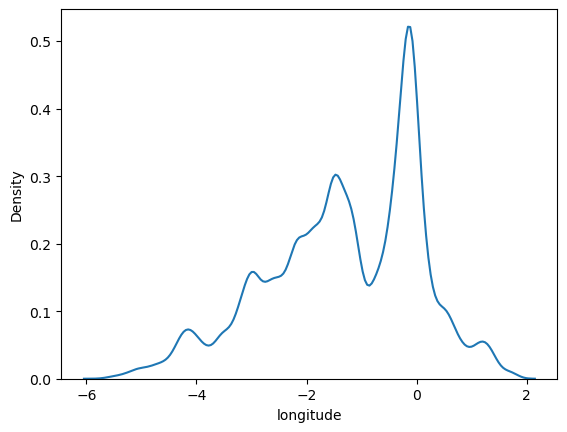

In [267]:
sns.kdeplot(df.longitude)
plt.show()

-0.467 skewness so the feature considered normally distributed

### latitude

In [268]:
df.latitude.skew()

0.8904421482893198

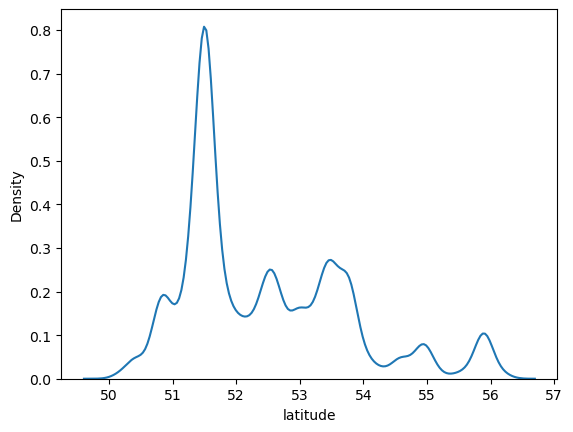

In [269]:
sns.kdeplot(df.latitude)
plt.show()

0.89 skewness so the feature considered normally distributed

### number_of_vehicles

In [270]:
df.number_of_vehicles.skew()

1.1798472179508745

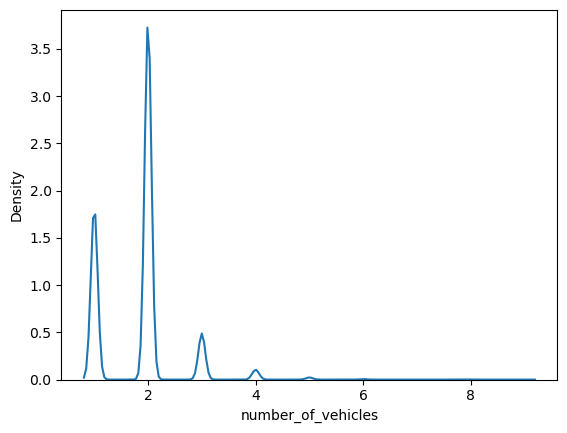

In [271]:
sns.kdeplot(df.number_of_vehicles)
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


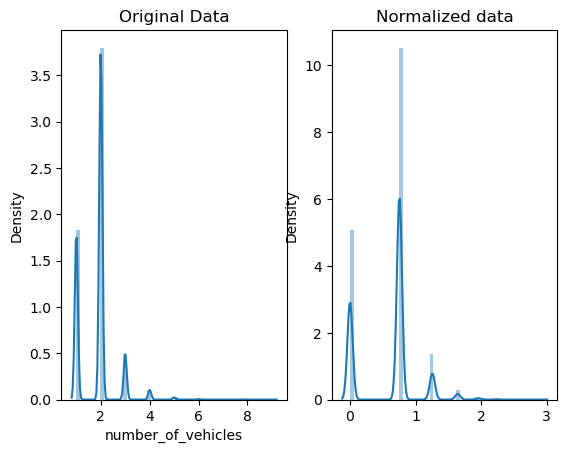

In [272]:
df['number_of_vehicles'] = Box_Cox(df,'number_of_vehicles')

skewness >1 so it needs to be normlized since it is not normal

### number_of_casualties

In [273]:
df.number_of_casualties.skew()

3.371201385124412

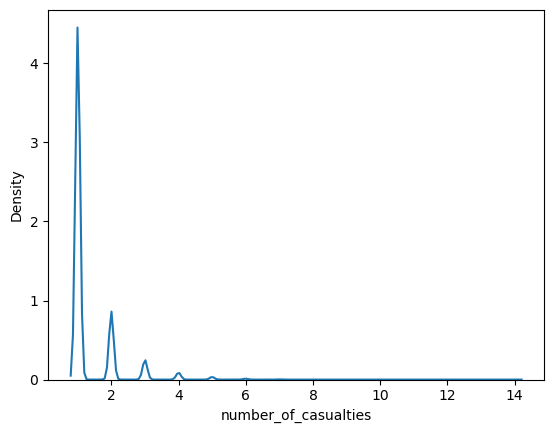

In [274]:
sns.kdeplot(df.number_of_casualties)
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


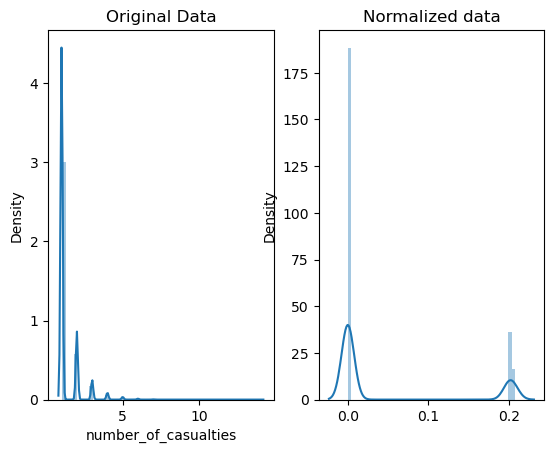

In [275]:
df['number_of_casualties'] = Box_Cox(df,'number_of_casualties')

skewness >1 so it needs to be normlized since it is not normal

### speed_limit

In [276]:
df.speed_limit.skew()

1.2123353599361841

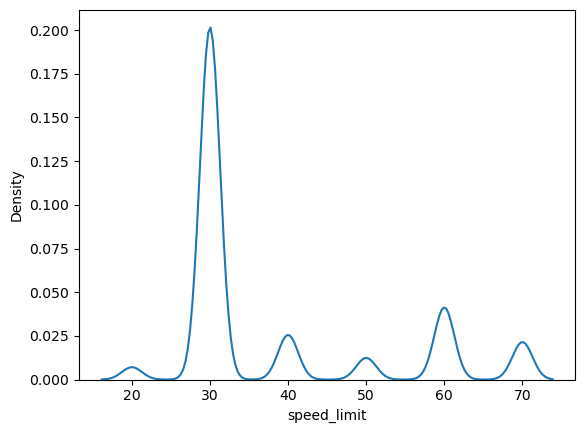

In [277]:
sns.kdeplot(df.speed_limit)
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


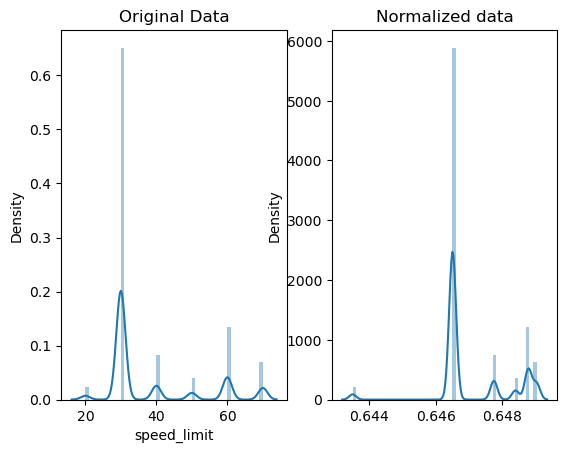

In [278]:
df['speed_limit'] = Box_Cox(df,'speed_limit')

# Exporting the dataframe to a csv file

In [279]:
df.to_csv(output_path_csv,index=True)